In [1]:
#import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import data
df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv")


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


In [3]:
#convert column to datatime and set as index 

df["Month"] = pd.to_datetime(df['Month'])
df.set_index("Month", inplace = True)

df.head(10)

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


Text(0, 0.5, 'Passengers')

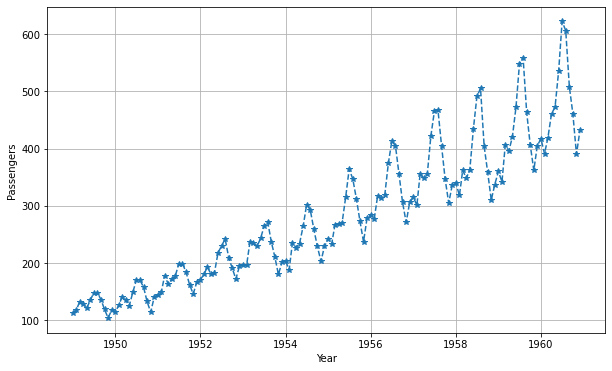

In [4]:
#plot a graph of the dataset

plt.figure(figsize = (10,6))
plt.plot(df.index, df.Passengers, "--", marker = "*")
plt.grid()
plt.xlabel("Year")
plt.ylabel("Passengers")


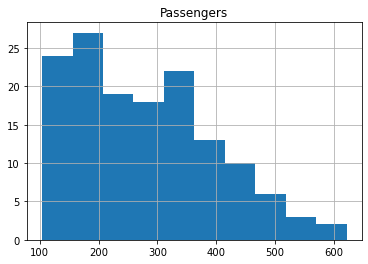

In [5]:
df.hist()
plt.show()

In [6]:
#check for missing data

df.isnull().values.any()

False

### Since there are no missing values in our dataset we will generate missing values and show how to resolve it

In [7]:
#making a copy of the dataset for this example
df_copy = df.copy()

#taking a 10th of the copied data and storing it as rows
rows = df_copy.sample(frac = 0.1, random_state = 0)

#assigning the values of Passengers in rows as NaN
rows["Passengers"] = np.nan

#selecting the sample we created from our copy df and assigning as the NaN values in rows 
df_copy.loc[rows.index, "Passengers"] = rows["Passengers"]

df_copy.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [8]:
#cheeck for missing values in our copy dataset
df_copy.isnull().sum()

Passengers    14
dtype: int64

In [9]:
#There are 14 missing values in our copy data


#Filling by imputation - Forward fill
df_copy_ffill = df_copy.fillna(method = "ffill")

#check if there are still missing values
df_copy_ffill.isnull().sum()

Passengers    0
dtype: int64

In [10]:
#Filling by imputation - Backward fill
df_copy_bfill = df_copy.fillna(method = "bfill")

#check if there are still missing values
df_copy_bfill.isnull().sum()

Passengers    0
dtype: int64

In [11]:
#Filling by interpolation
df_copy_LIF = df_copy.interpolate(method = "linear", limit_direction = "forward")

#check if the values have been filled
df_copy_LIF.isnull().sum()

Passengers    0
dtype: int64

In [12]:
#Filling by interpolation
df_copy_LIB = df_copy.interpolate(method = "linear", limit_direction = "backward")


#check if values are filled
df_copy_LIB.isnull().sum()

Passengers    0
dtype: int64

Text(0, 0.5, 'Passengers')

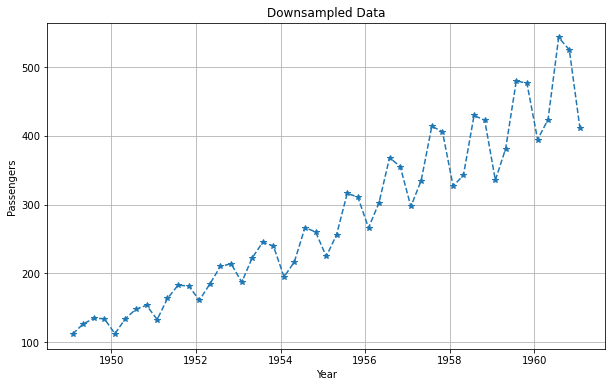

In [13]:
#Downsampling to Quarterly data points
df_quarterly = df.resample("3M").mean()

#plot a graph of the dataset

plt.figure(figsize = (10,6))
plt.plot(df_quarterly.index, df_quarterly.Passengers, "--", marker = "*")
plt.grid()
plt.title("Downsampled Data")
plt.xlabel("Year")
plt.ylabel("Passengers")

Text(0, 0.5, 'Passengers')

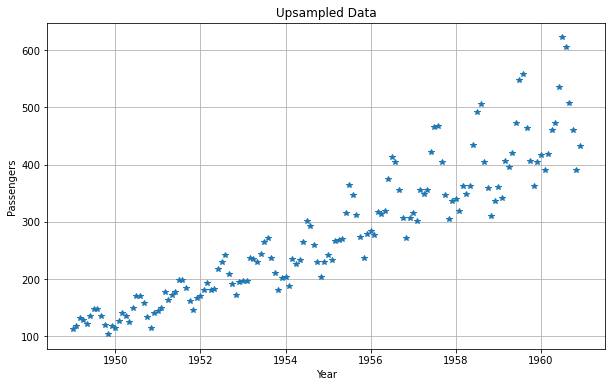

In [14]:
#Upsampling to Daily data points
df_daily = df.resample("D").mean()

#plot a graph of the dataset

plt.figure(figsize = (10,6))
plt.plot(df_daily.index, df_daily.Passengers, "--", marker = "*")
plt.grid()
plt.title("Upsampled Data")
plt.xlabel("Year")
plt.ylabel("Passengers")

In [15]:
#Moving average smoothing 
df_MA = df.copy()
moving_avr = df_MA["Passengers"].rolling(12).mean()

Text(0, 0.5, 'Passengers')

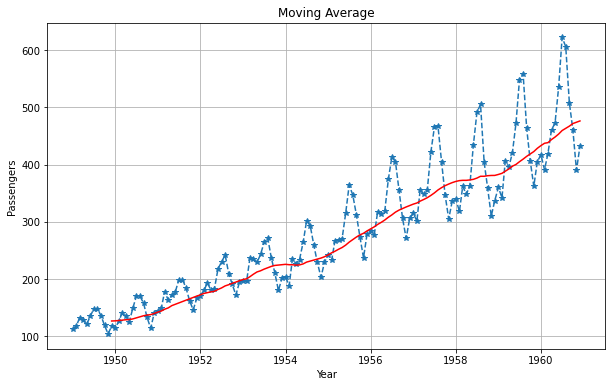

In [16]:
#plot a graph of the dataset

plt.figure(figsize = (10,6))
plt.plot(df.index, df.Passengers, "--", marker = "*")
plt.plot(df.index, moving_avr, "r-")
plt.grid()
plt.title("Moving Average")
plt.xlabel("Year")
plt.ylabel("Passengers")


### Time Series Specific Extrapolatory Methods

In [17]:
import statsmodels.api as sm
from pylab import rcParams


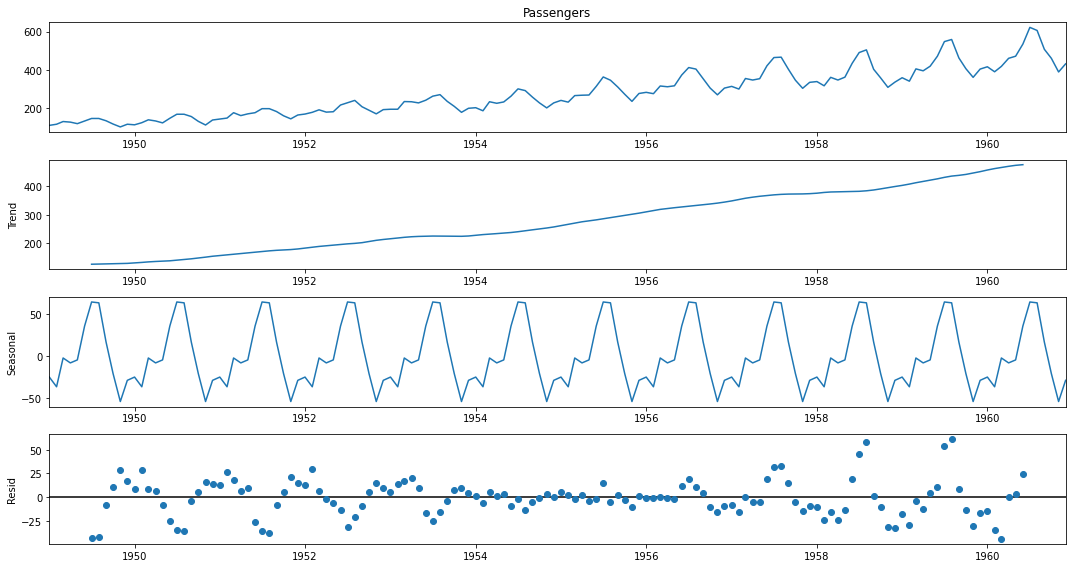

In [18]:
rcParams["figure.figsize"] = 15, 8
decompose_series = sm.tsa.seasonal_decompose(df["Passengers"], model = "additive")
decompose_series.plot()
plt.show()


#### The decomposed time series show an obvious increasing trend and seasonality variations. 

#### Recall that we have initially plotted the moving average on the last 12 months which showed that it varies with time. 

#### This suggests that the data is not stationary. 

#### We will now perform an ADF test to confirm this speculation

In [19]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df["Passengers"])

print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"No of lags used: {adf_result[2]}")
print(f"No of observations used: {adf_result[3]}")
print("Critical Values: ")

for k, v in adf_result[4].items():
    print(f" {k}: {v}")

ADF Statistic: 0.8153688792060556
p-value: 0.9918802434376411
No of lags used: 13
No of observations used: 130
Critical Values: 
 1%: -3.4816817173418295
 5%: -2.8840418343195267
 10%: -2.578770059171598


Text(0, 0.5, 'Passengers')

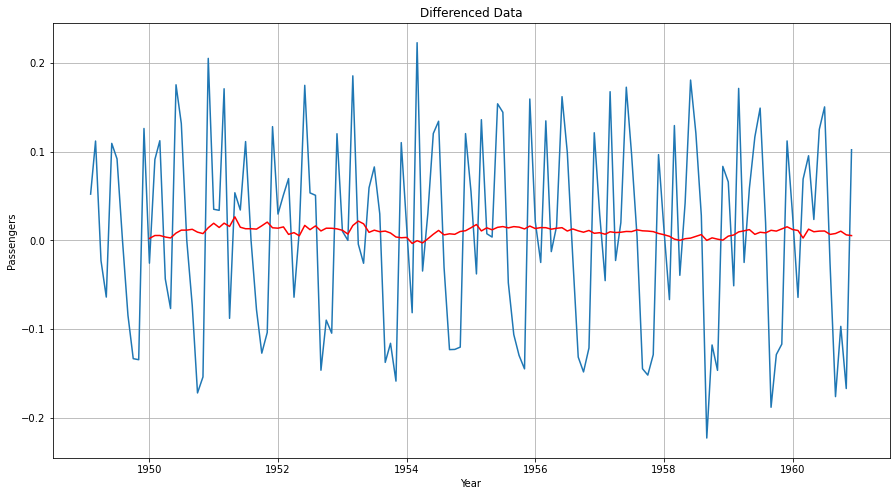

In [20]:
#From the results obtained, the p-value is greater than the critical value at a 5% #significance level 
#and, the ADF statistic is greater that any of the critical values obtain. 
#This confirms that the series is indeed non-stationary.
#Convert time series to stationary by removing trend and seasonality
#Transformation and Differencing

df_log = np.log(df)
df_diff = df_log.diff(periods = 1)
plt.plot(df_diff.index, df_diff.Passengers, "-")
plt.plot(df_diff.rolling(12).mean(), color = "red")
plt.grid()
plt.title("Differenced Data")
plt.xlabel("Year")
plt.ylabel("Passengers")

In [21]:
from statsmodels.tsa.arima_model import ARIMA 


In [22]:
df_diff.isnull()


,Passengers
Month,
1949-01-01,True
1949-02-01,False
1949-03-01,False
1949-04-01,False
1949-05-01,False
...,...
1960-08-01,False
1960-09-01,False
1960-10-01,False


In [23]:
df_diff = df_diff.fillna(method = "bfill")
df_diff.isnull().sum()

Passengers    0
dtype: int64

#### AR Model

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0, 0.5, 'Passengers')

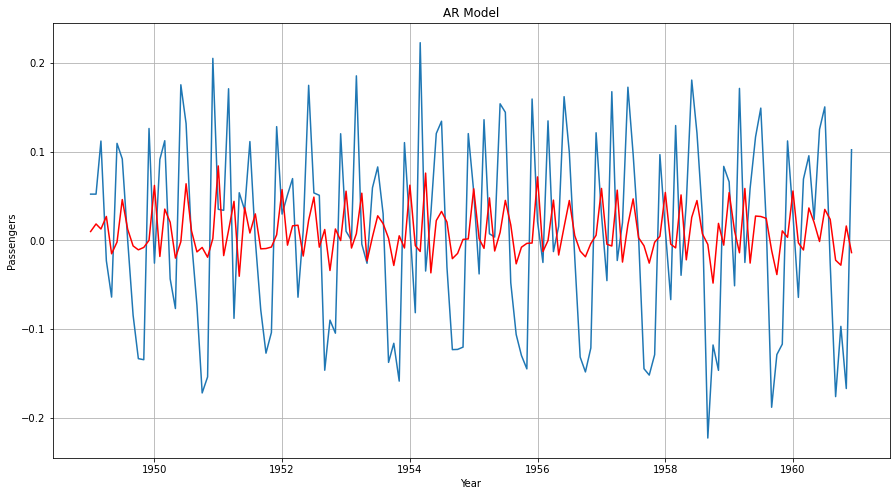

In [24]:
AR_model = ARIMA(df_diff, order = (2,0,0))
AR_model_results = AR_model.fit()
plt.plot(df_diff)
plt.plot(AR_model_results.fittedvalues, color = "red")
plt.grid()
plt.title("AR Model")
plt.xlabel("Year")
plt.ylabel("Passengers")

#### MA Model

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'MA Model')

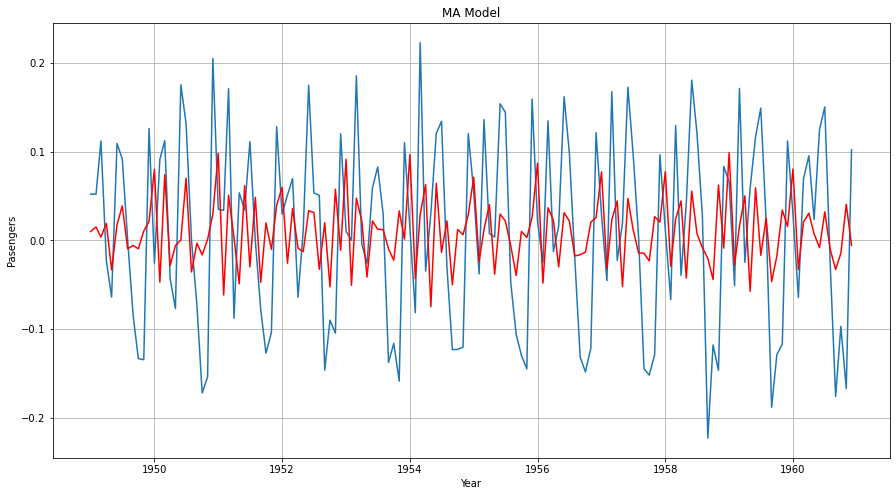

In [25]:
MA_model = ARIMA(df_diff, order = (0,0,2))
MA_model_results = MA_model.fit()
plt.plot(df_diff)
plt.plot(MA_model_results.fittedvalues, color = "red")
plt.grid()
plt.xlabel("Year")
plt.ylabel("Pasengers")
plt.title("MA Model")


#### ARIMA Model

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0, 0.5, 'Passengers')

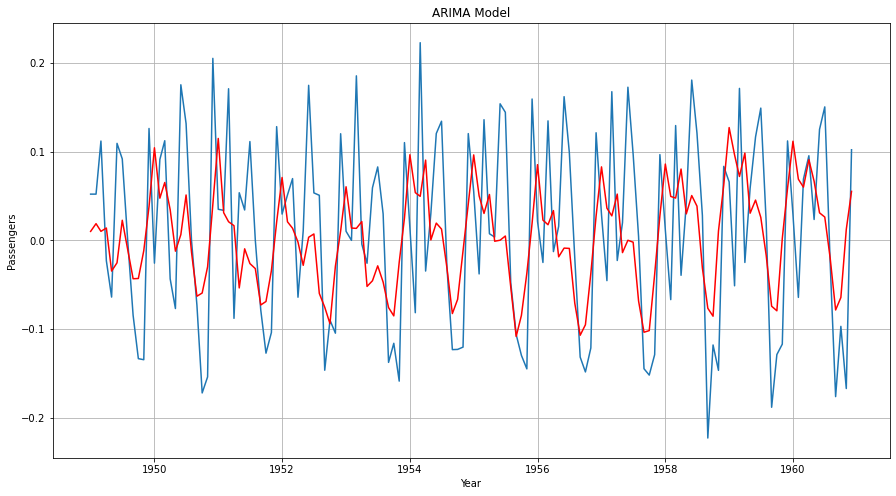

In [26]:
ARIMA_model = ARIMA(df_diff, order = (2,0,1))
ARIMA_results = ARIMA_model.fit()
plt.plot(df_diff)
plt.plot(ARIMA_results.fittedvalues, color ="red")
plt.grid()
plt.title("ARIMA Model")
plt.xlabel("Year")
plt.ylabel("Passengers")

In [27]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



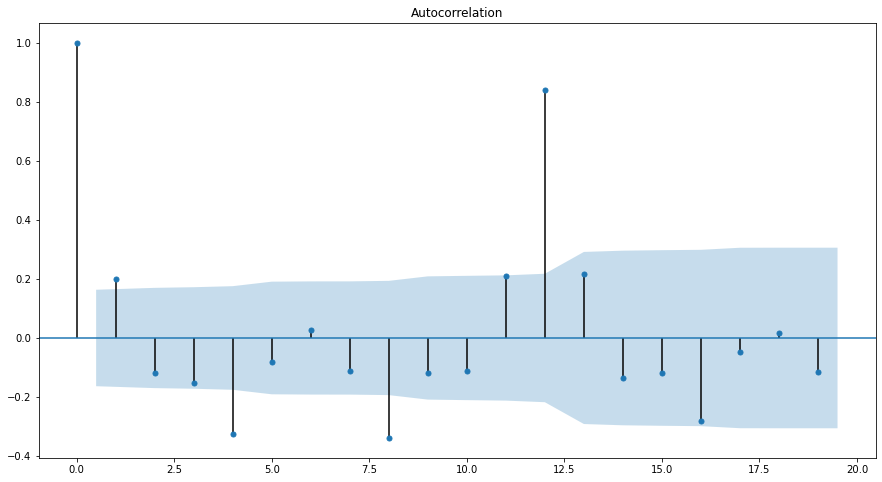

In [28]:
#ACF
plot_acf(df_diff, lags = range(0, 20))
plt.show()

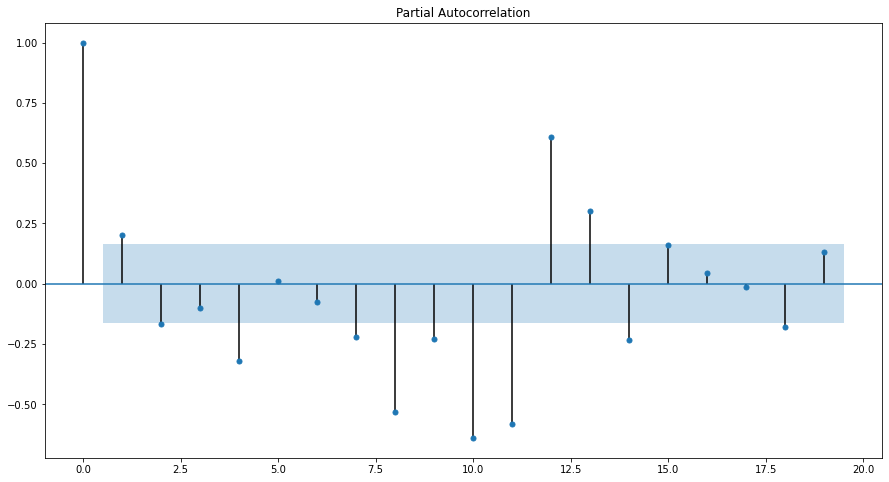

In [29]:
#PACF
plot_pacf(df_diff, lags = range(0,20))
plt.show()

In [30]:
from fbprophet import Prophet

df.head()

ModuleNotFoundError: No module named 'fbprophet'